# FreshGoGo Two Months Sales DataSet Analytic 

案例背景：現有超市購物中心客戶的一些基本數據，如客戶ID,消費金額,訂購金額,訂購時間.
需要解决问题：利用现有资料，划分不同客户类型，以便可以了解哪些客户为超市优质客户，并向营销团队提供意见。
1.Python模型跟數據導入
2.兩種資料格式合併與資料處理
3.最佳商品分析分析
4.銷售時間點分析
5.客單量分析

# 1.1 Python模型跟數據導入

使用的庫主要有：pandas、numpy、matplotlib、seaborn
使用的數據集：
Order+data+20200629-20200712.csv
Order+data+20200713-20200726.csv
xiaoshouliushui20200629-0712.xlsx
xiaoshouliushui20200713-0726.xlsx

In [4]:
import numpy as np                               # 向量和矩阵运算
import pandas as pd                              # 表格与数据处理
import matplotlib.pyplot as plt                  # 绘图
import seaborn as sns                            # 更多绘图功能
sns.set()

from dateutil.relativedelta import relativedelta # 日期数据处理
from scipy.optimize import minimize              # 优化函数

import statsmodels.formula.api as smf            # 数理统计
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # 一些有用的函数
from tqdm import tqdm_notebook

# 1.2 數據導入並讀取訂單資料

數據導入並讀取 csv 訂單資料

In [5]:
#Sales 20200629-0712 as file 1
#Sales 20200713-0726 as file 2
file1=open(r"/Users/annettechiu/Desktop/FreshGoGo/Order+data+20200629-20200712.csv",encoding='utf-8')
file2=open(r"/Users/annettechiu/Desktop/FreshGoGo/Order+data+20200713-20200726.csv",encoding='utf-8')
freshgogo1 = pd.read_csv(file1)
freshgogo2 = pd.read_csv(file2)

數據導入並讀取訂單資料（讀取六月跟七月的訂單的產品內容）

In [6]:
#Sales with product information 20200629-0712 as file 3
#Sales with product information 20200713-0726 as file 4
files3 = pd.read_excel('/Users/annettechiu/Desktop/FreshGoGo/xiaoshouliushui20200629-0712.xlsx')
files4 = pd.read_excel('/Users/annettechiu/Desktop/FreshGoGo/xiaoshouliushui20200713-0726.xlsx')
#freshgogo1 = pd.read_excel(file3)
#freshgogo2 = pd.read_excel(file4)
files3.head(2)

,下单日期,订单号,送货日期,用户ID,供应商,SKU ID,商品名称（中文）,商品名称（英文）,税类,订购数量,商品单价,税金,总价
0,2020-06-29,1594699128,2020-07-16,55586018823,自营冻品分拣,12095,加拿大龙岗走地鸡(冷冻)(拼团)(*),NaN,Other Categories,5,23.99,0.0,119.95
1,2020-06-29,1598776640,2020-07-02,58991718899,自营批发蔬菜,11001,芫茜(香菜),NaN,Grocery,1,1.29,0.0,1.29


In [7]:
freshgogo1.head(2)

,Order Number,Order Time,Cust ID,Delivery Date,订单投诉,Status,Total Price,Payment,Voucher Discount,Voucher,...,Customer Service,OS of App,Unnamed: 17,冷链包装费,支付宝手续费,会员券,配送费,到家/自提,班次,服务费
0,1594699128,6/29/2020 0:00,55586018823,7/16/2020,NaN,已送达,119.95,信用卡支付,NaN,NaN,...,NaN,ios,2.3.0,1.5,NaN,0,0.00,自提,NY,0
1,1598776640,6/29/2020 0:03,58991718899,7/2/2020,NaN,已送达,147.34,信用卡支付,NaN,NaN,...,NaN,ios,2.3.0,1.5,NaN,0,6.99,到家,NY,0


In [8]:
freshgogo2.head(2)

,Order Number,Order Time,用户ID,Delivery Date,订单投诉,Status,Total Price,Payment,Voucher Discount,Voucher,...,Customer Service,OS of App,Unnamed: 17,冷链包装费,支付宝手续费,会员券,配送费,到家/自提,班次,服务费
0,1601116468,7/13/2020 0:00,58351892017,7/22/2020,NaN,已送达,118.18,信用卡支付,NaN,NaN,...,R-商品变质,ios,2.3.1,1.5,NaN,5,0.0,自提,DC,0
1,1602472924,7/13/2020 0:01,55085937222,7/18/2020,NaN,已送达,298.84,余额支付,NaN,NaN,...,NaN,ios,2.3.1,1.5,NaN,5,0.0,自提,OT,0


# 2.1 將兩個月的銷售數據還有訂單內容合併

使用Concat函式將兩個月的訂單資訊合併

In [9]:
frames = [freshgogo1, freshgogo2]
Result = pd.concat(frames)

In [10]:
Result.head(2)

,Order Number,Order Time,Cust ID,Delivery Date,订单投诉,Status,Total Price,Payment,Voucher Discount,Voucher,...,OS of App,Unnamed: 17,冷链包装费,支付宝手续费,会员券,配送费,到家/自提,班次,服务费,用户ID
0,1594699128,6/29/2020 0:00,5.558602e+10,7/16/2020,NaN,已送达,119.95,信用卡支付,NaN,NaN,...,ios,2.3.0,1.5,NaN,0,0.00,自提,NY,0,NaN
1,1598776640,6/29/2020 0:03,5.899172e+10,7/2/2020,NaN,已送达,147.34,信用卡支付,NaN,NaN,...,ios,2.3.0,1.5,NaN,0,6.99,到家,NY,0,NaN


In [11]:
Result.to_pickle('/Users/annettechiu/Desktop/FreshGoGo/Order+data+20200629-20200726.csv')

In [12]:
Result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24050 entries, 0 to 11955
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order Number      24050 non-null  int64  
 1   Order Time        24050 non-null  object 
 2   Cust ID           12094 non-null  float64
 3   Delivery Date     24050 non-null  object 
 4   订单投诉              1035 non-null   object 
 5   Status            24050 non-null  object 
 6   Total Price       24050 non-null  float64
 7   Payment           24050 non-null  object 
 8   Voucher Discount  705 non-null    float64
 9   Voucher           705 non-null    object 
 10  Coupon Discount   54 non-null     float64
 11  Coupon            54 non-null     object 
 12  Tax Price         24050 non-null  float64
 13  Final Price       24050 non-null  float64
 14  Refund            12761 non-null  float64
 15  Customer Service  1514 non-null   object 
 16  OS of App         24050 non-null  object

In [13]:
Result.isnull().sum(axis=0)

Order Number            0
Order Time              0
Cust ID             11956
Delivery Date           0
订单投诉                23015
Status                  0
Total Price             0
Payment                 0
Voucher Discount    23345
Voucher             23345
Coupon Discount     23996
Coupon              23996
Tax Price               0
Final Price             0
Refund              11289
Customer Service    22536
OS of App               0
Unnamed: 17          6058
冷链包装费                2914
支付宝手续费              22511
会员券                     0
配送费                     0
到家/自提                   0
班次                      0
服务费                     0
用户ID                12094
dtype: int64

# 將資料重新命名

In [14]:
Result.rename(columns={"订单投诉":"complaint","会员券":"membership","配送费":"delivery_fee","到家/自提":"Delivery/Pick_up"},inplace=True)

# 2.2 將兩個月的產品銷售數據訂單合併

In [15]:
frames2 = [files3, files4]
Product = pd.concat(frames2)
Product.head(2)

,下单日期,订单号,送货日期,用户ID,供应商,SKU ID,商品名称（中文）,商品名称（英文）,税类,订购数量,商品单价,税金,总价
0,2020-06-29,1594699128,2020-07-16,55586018823,自营冻品分拣,12095,加拿大龙岗走地鸡(冷冻)(拼团)(*),NaN,Other Categories,5,23.99,0.0,119.95
1,2020-06-29,1598776640,2020-07-02,58991718899,自营批发蔬菜,11001,芫茜(香菜),NaN,Grocery,1,1.29,0.0,1.29


# 2.3 將訂單資訊跟產品銷售數據訂單合併                                      Group By Two Dataframe Table via Order ID 

The First Dataframe is " Result " dataframe and "Product" is about product infomation.

In [16]:
#如果 Join 依據左表格 Number ID, 找兩者交集只有436661筆資料, 因此選擇how="left" 產生448852筆資料
df = pd.merge(Result,Product,how="left") 
df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448852 entries, 0 to 448851
Data columns (total 38 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order Number      448852 non-null  int64         
 1   Order Time        448852 non-null  object        
 2   Cust ID           12094 non-null   float64       
 3   Delivery Date     448852 non-null  object        
 4   complaint         17125 non-null   object        
 5   Status            448852 non-null  object        
 6   Total Price       448852 non-null  float64       
 7   Payment           448852 non-null  object        
 8   Voucher Discount  9420 non-null    float64       
 9   Voucher           9420 non-null    object        
 10  Coupon Discount   843 non-null     float64       
 11  Coupon            843 non-null     object        
 12  Tax Price         448852 non-null  float64       
 13  Final Price       448852 non-null  float64       
 14  Refu

＃數據清理參考需要跟團隊討論後修正

In [17]:
#如果想要用 mean / median 等數字填充,可以使用 fillna() ，後面加上特定的公式帶入。
# Calculate the mean of the delivery_fee column: delivery_fee
delivery_fee_mean = df.delivery_fee.mean()
# Replace all the missing values in the Ozone column with the mean
df['delivery_fee'] = df.delivery_fee.fillna(delivery_fee_mean)
# Print the info of airquality
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448852 entries, 0 to 448851
Data columns (total 38 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order Number      448852 non-null  int64         
 1   Order Time        448852 non-null  object        
 2   Cust ID           12094 non-null   float64       
 3   Delivery Date     448852 non-null  object        
 4   complaint         17125 non-null   object        
 5   Status            448852 non-null  object        
 6   Total Price       448852 non-null  float64       
 7   Payment           448852 non-null  object        
 8   Voucher Discount  9420 non-null    float64       
 9   Voucher           9420 non-null    object        
 10  Coupon Discount   843 non-null     float64       
 11  Coupon            843 non-null     object        
 12  Tax Price         448852 non-null  float64       
 13  Final Price       448852 non-null  float64       
 14  Refu

# 3.1 暢銷商品分析

In [18]:
df["Sales"] = df["总价"]
df["Product"] = df["商品名称（中文）"]
df["Supplier"] = df["供应商"]

找到最熱門的產品還有供應商

In [19]:
Product_Sales = df.groupby(['Product','Supplier']).agg({'Sales':'sum'})
Product_Sales["percent"] = Product_Sales["Sales"] /df["Sales"].sum()
Product_Sales.style.background_gradient()

In [20]:
Supplier_Sales = df.groupby(['Supplier']).agg({'Sales':'sum'})
Supplier_Sales.style.background_gradient()

,Sales
Supplier,
46号美食店,6702.510000
FreshGoGo自营,1215272.119999
Miss Li,3048.530000
【下架】不老鸡不老鸭,174.920000
【下架】车轮饼,3317.160000
上海壹丰园,4970.910000
上海壹丰园-冷冻,12521.690000
上海壹丰园-冷菜,5109.580000
上海老正兴,1708.540000


In [21]:
# 销量top10 商品
productId_count = df.groupby('商品名称（中文）').count()['用户ID'].sort_values(ascending=False)
print(productId_count.head(10))

商品名称（中文）
葱(低价)       7293
莴苣          4327
绍菜(低价)      3963
中国茄子(低价)    3819
番茄(低价)      3656
上海菜(低价)     3458
蒜头(低价)      3233
姜(低价)       3203
上海苗(低价)     3173
空心菜         3125
Name: 用户ID, dtype: int64


In [22]:
#销售额top10商品
productId_amount = df.groupby('商品名称（中文）').sum()['Sales'].sort_values(ascending=False)
print(productId_amount.head(10))
 
#销售额top10 供應商
productId_Profit = df.groupby('Supplier').sum()['Sales'].sort_values(ascending=False)
print(productId_Profit.head(10))

商品名称（中文）
肥牛肉片                 29392.82
散装黑叶荔枝(限量)           25224.68
金钱腱(低价)              23468.21
(1.5磅)金沙骨(低价)        21891.98
绍菜(低价)               21029.46
招牌鱼饺(冷冻)(限量)【鱼饺子】    18495.72
空心菜                  18381.60
莴苣                   17264.13
天津黄瓜                 16967.11
无骨五花肉(低价)            16654.98
Name: Sales, dtype: float64
Supplier
FreshGoGo自营    1.215272e+06
自营批发蔬菜         7.704000e+05
自营冻品分拣         7.638637e+04
德昌肉品           6.209111e+04
老豫园-冷冻         6.142827e+04
凯诗琳            5.668518e+04
上海豫园           4.207482e+04
鱼饺子-冷冻         3.958217e+04
大班饼店           3.717856e+04
老北京            3.693188e+04
Name: Sales, dtype: float64


# 4.1 銷售時間點分析

In [23]:
dt= df["Order Time"].astype(str) #转换成字符串格式

In [24]:
dt

0          6/29/2020 0:00
1          6/29/2020 0:03
2          6/29/2020 0:04
3          6/29/2020 0:04
4          6/29/2020 0:08
               ...       
448847    7/26/2020 23:59
448848    7/26/2020 23:59
448849    7/26/2020 23:59
448850    7/26/2020 23:59
448851    7/26/2020 23:59
Name: Order Time, Length: 448852, dtype: object

In [25]:
from datetime import datetime

In [26]:
dt = dt.apply(lambda x:datetime.strptime(x,'%m/%d/%Y %H:%M'))

In [27]:
df['month'] = dt.map(lambda x: x.month) #获取月份，并添加列month
df['year'] = dt.map(lambda x: x.year)
df['day'] = dt.map(lambda x: x.day)
df['hour'] = dt.map(lambda x: x.hour)
df['minute'] = dt.map(lambda x: x.minute)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448852 entries, 0 to 448851
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order Number      448852 non-null  int64         
 1   Order Time        448852 non-null  object        
 2   Cust ID           12094 non-null   float64       
 3   Delivery Date     448852 non-null  object        
 4   complaint         17125 non-null   object        
 5   Status            448852 non-null  object        
 6   Total Price       448852 non-null  float64       
 7   Payment           448852 non-null  object        
 8   Voucher Discount  9420 non-null    float64       
 9   Voucher           9420 non-null    object        
 10  Coupon Discount   843 non-null     float64       
 11  Coupon            843 non-null     object        
 12  Tax Price         448852 non-null  float64       
 13  Final Price       448852 non-null  float64       
 14  Refu

In [28]:
#对data进行按Order Date日期进行排序
fg_result=df.sort_values(by='Order Time',ascending=True,na_position='first')#把转化异常的数据放上面

In [29]:
#选取销售分析数据子集
sales_data=df[['Order Time','Total Price','Final Price','year','month','day','minute']]
sales_data.head()

,Order Time,Total Price,Final Price,year,month,day,minute
0,6/29/2020 0:00,119.95,121.45,2020,6,29,0
1,6/29/2020 0:03,147.34,160.29,2020,6,29,3
2,6/29/2020 0:04,89.30,86.53,2020,6,29,4
3,6/29/2020 0:04,45.45,59.18,2020,6,29,4
4,6/29/2020 0:08,247.80,262.20,2020,6,29,8


In [30]:
sales_year = sales_data.groupby(['year','month']).sum()
sales_year

Total Price   Final Price      day    minute
year month                                               
2020 6      2.279870e+05  2.422636e+05    51723     51958
     7      6.440391e+07  6.790456e+07  8614499  13416541

In [31]:
import seaborn as sns

In [32]:
sales = pd.read_csv('/Users/annettechiu/Desktop/FreshGoGo/Order+data+20200629-20200712.csv', index_col=['Order Time'], parse_dates=['Order Time'])
sales.head()

,Order Number,Cust ID,Delivery Date,订单投诉,Status,Total Price,Payment,Voucher Discount,Voucher,Coupon Discount,...,Customer Service,OS of App,Unnamed: 17,冷链包装费,支付宝手续费,会员券,配送费,到家/自提,班次,服务费
Order Time,,,,,,,,,,,,,,,,,,,,,
2020-06-29 00:00:00,1594699128,55586018823,7/16/2020,NaN,已送达,119.95,信用卡支付,NaN,NaN,NaN,...,NaN,ios,2.3.0,1.5,NaN,0,0.00,自提,NY,0
2020-06-29 00:03:00,1598776640,58991718899,7/2/2020,NaN,已送达,147.34,信用卡支付,NaN,NaN,NaN,...,NaN,ios,2.3.0,1.5,NaN,0,6.99,到家,NY,0
2020-06-29 00:04:00,1597710951,57851868718,7/4/2020,NaN,已送达,89.30,信用卡支付,5.0,新FAF【邀请有礼】【被邀请人】满$25减$5 活动至20201231结束,NaN,...,NaN,android,2.3.0,1.5,NaN,0,0.00,自提,OT,0
2020-06-29 00:04:00,1595995162,58431571996,7/2/2020,NaN,已送达,45.45,PayPal,NaN,NaN,NaN,...,NaN,ios,2.3.0,1.5,NaN,0,9.99,到家,NY,2
2020-06-29 00:08:00,1602053507,59691743730,7/5/2020,FGG责任,已送达,247.80,信用卡支付,NaN,NaN,NaN,...,R-质量问题,ios,2.3.0,1.5,NaN,0,9.99,到家,NY,0


In [33]:
sales_data=sales[['Total Price','Final Price']]
sales_data.head()

,Total Price,Final Price
Order Time,,
2020-06-29 00:00:00,119.95,121.45
2020-06-29 00:03:00,147.34,160.29
2020-06-29 00:04:00,89.30,86.53
2020-06-29 00:04:00,45.45,59.18
2020-06-29 00:08:00,247.80,262.20


In [34]:
sales_data.columns=['Total','Final']

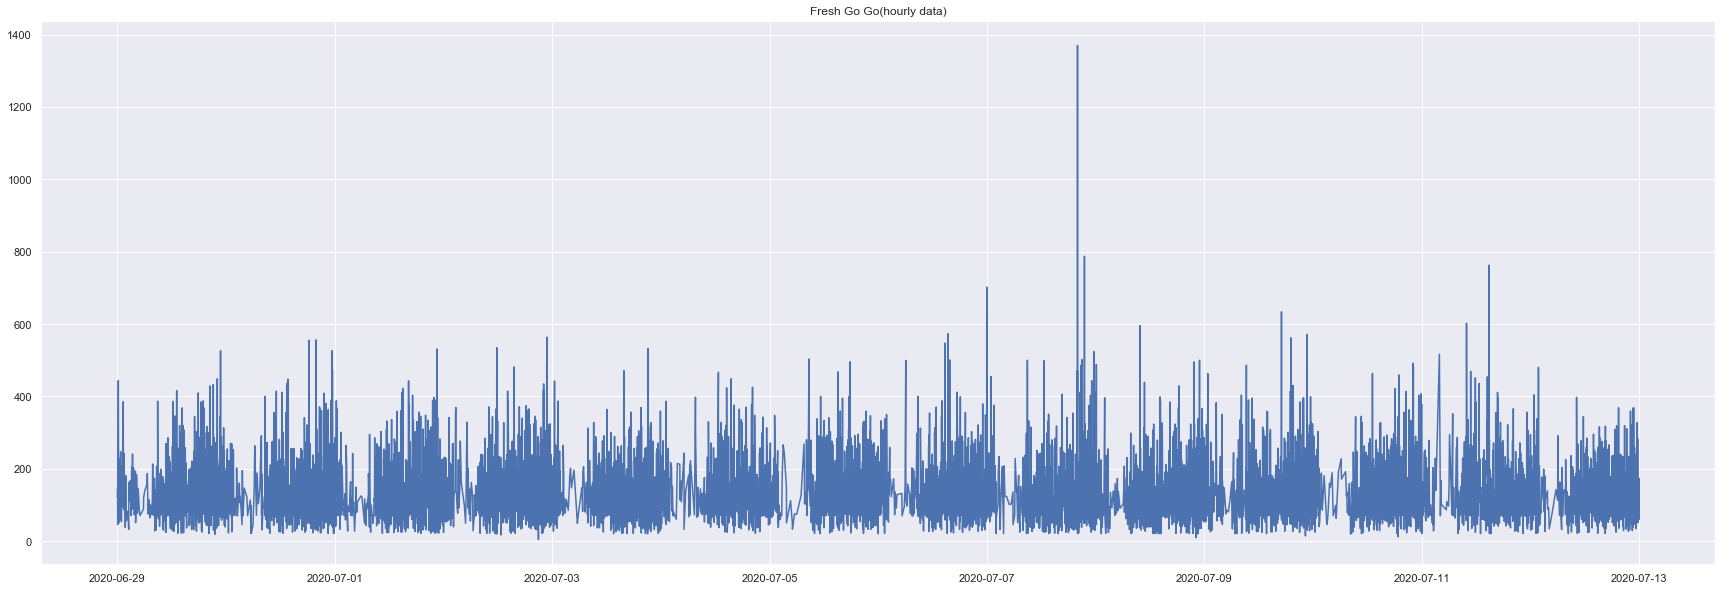

In [35]:
plt.figure(figsize=(30, 10))
plt.plot(sales_data.Total)
plt.title('Fresh Go Go(hourly data)')
plt.grid(True)
plt.show()

# 5.客單量分析

客單價是指商場（超市）每一個顧客平均購買商品的金額，客單價也即是平均交易金額。
從某種程度上反映了企業的消費群體的許多特點以及企業的銷售類目的盈利狀態是否健康。
總消費次數：同一天內，同一個人發生的所有消費算作一次消費。

客單價=總消費金額 / 總消費次數

In [70]:
price=df[['Order Time','Cust ID','Sales','订购数量']]

In [71]:
price.rename(columns={"Order Time":"order_time"},inplace=True)

/Users/annettechiu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [72]:
# 計算總消費次數
price_dr=price.drop_duplicates(subset=['order_time', 'Cust ID'])
# 總消費次數：有多少行
total_num=price_dr.shape[0]
print('兩個月總消費次數=',total_num)
unit_price = price['Sales'].sum()/total_num
print('兩個月客單價=', unit_price,'\n')

兩個月總消費次數= 20320
兩個月客單價= 153.11689271653543 



In [73]:
grouped_Customer = price[['Cust ID','order_time','Sales']].sort_values(['order_time']).groupby('Cust ID') 
grouped_Customer.head()

,Cust ID,order_time,Sales
0,5.558602e+10,6/29/2020 0:00,NaN
1,5.899172e+10,6/29/2020 0:03,NaN
2,5.785187e+10,6/29/2020 0:04,NaN
3,5.843157e+10,6/29/2020 0:04,NaN
4,5.969174e+10,6/29/2020 0:08,NaN
...,...,...,...
8940,5.236078e+10,7/9/2020 9:55,NaN
8941,5.788069e+10,7/9/2020 9:56,NaN
8942,5.457743e+10,7/9/2020 9:57,NaN
8943,5.696464e+10,7/9/2020 9:58,NaN


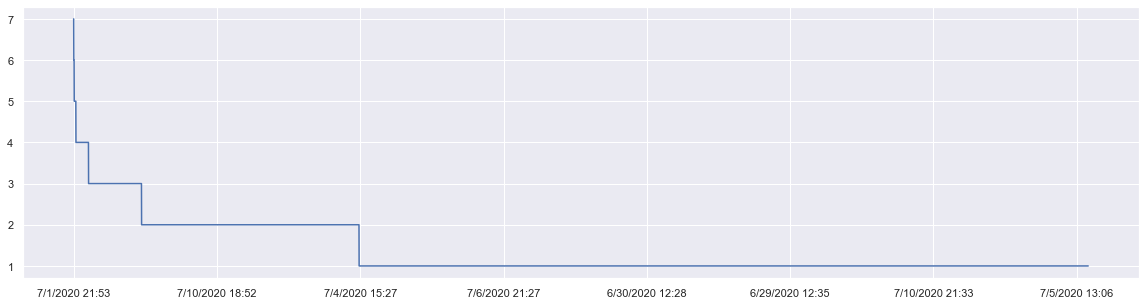

In [74]:
#看一下用戶的第一次購買日期分布
grouped_Customer.min().order_time.value_counts().plot(figsize=(20,5))

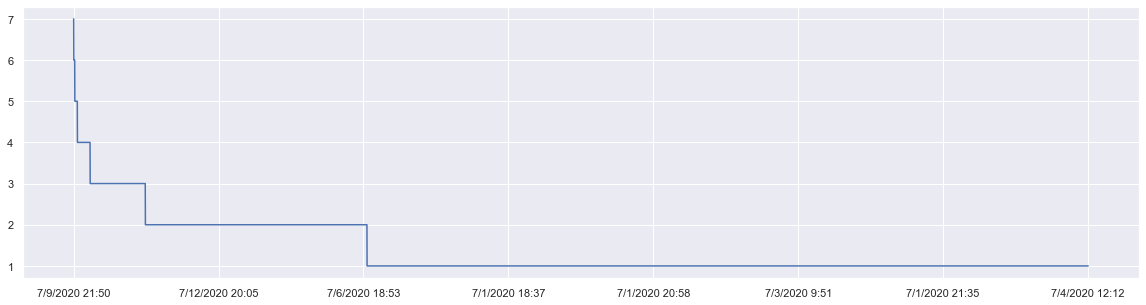

In [75]:
#再來看一下用戶的最後一次購買日期分布
grouped_Customer.max().order_time.value_counts().plot(figsize=(20,5))

從上面可以看出， 從7月初以後新用戶增長的趨勢緩慢，商家可以通過廣告等推廣策略吸收更多的新用戶；
而通過觀察最近一次購買日期，可以發現用戶基本沒有流失，也驗證了每年銷售額的增長趨勢。
總體來說新客戶數量是在逐年遞減的，說明該企業老客戶的維繫不錯，
但新客獲取率較低。如果能夠在新客戶獲取上能夠突破，會給企業帶來很大的增長空間。

再來看看只購買過一次的客戶數量 ：

In [76]:
# 統計每個客戶第一次和最後一次購買記錄
Customer_life = grouped_Customer.order_time.agg(['min','max'])

In [77]:
# 查看只有一次購買記錄的顧客數量，第一次和最後一次是同一條記錄，則說明購買只有一次
(Customer_life['min'] == Customer_life['max']).value_counts()

True     7777
False    1895
dtype: int64

從結果來看，只購買一次的用戶有7777個，大部分用戶都會購買多次，說明回頭率很低，
也驗證了上面關於該企業老客戶的維繫不夠的結論。

# 6.RFM模型分析

RFM的含義：

R（Recency）：客戶最近一次交易時間的間隔。R值越大，表示客戶交易發生的日期越久，反之則表示客戶交易發生的日期越近。

F（Frequency）：客戶在最近一段時間內交易的次數。F值越大，表示客戶交易越頻繁，反之則表示客戶交易不夠活躍。

M（Monetary）：客戶在最近一段時間內交易的金額。M值越大，表示客戶價值越高，反之則表示客戶價值越低。

RFM分析就是根據客戶活躍程度和交易金額的貢獻，進行客戶價值細分的一種方法。

首先構建RFM表：



原文網址：https://kknews.cc/code/258oaxz.html

首先構建RFM表：

In [92]:
rfm = price.pivot_table(index='Cust ID', values = ["订购数量","Sales","order_time"], aggfunc={"订购数量":"sum","Sales":"sum","order_time":"max"}) 

In [95]:
# 所有用戶最大的交易日期為標準，求每筆交易的時間間隔即為R 
rfm['R'] = (rfm.order_time.max() - rfm.order_time)/np.timedelta64(1,'D') 
# 每個客戶的總銷量即為F，總銷售額即為M 
rfm.rename(columns={'订购数量':'F','Sales':'M'},inplace = True) 
rfm.head()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [85]:
rfm[['R','F','M']].apply(lambda x:x-x.mean())

KeyError: "None of [Index(['R', 'F', 'M'], dtype='object')] are in the [columns]"

In [86]:
def rfm_func(x): 
    level =x.apply(lambda x:'1'if x>0 else '0') 
    level =level.R +level.F +level.M 
    d = { "111":"重要價值客戶", "011":"重要保持客戶", "101":"重要挽留客戶", "001":"重要發展客戶", "110":"一般價值客戶", "010":"一般保持客戶", "100":"一般挽留客戶", "000":"一般發展客戶" } 
    result = d[level] 
    return result